In [1]:
# load libraries
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation


In [28]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '1096.SUB12877_lipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 

sample_dictionary = {'s1':'WT',
                     's2':'G2',
                     's3':'WT',
                     's4':'G2',
                     's5':'G2+choline'}

lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'blue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

In [29]:
# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT', 'G2')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

stats.head()

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,cat,name,grp,class,carbons,unsaturations,unsat_grp
Cer(d15:0_26:2)-H_47.3,-1.833421,0.097373,-0.612545,0.209547,other,Cer(d15:0_26:2)-H_47.3,Sphingolipids,Cer,41,2,PUFA
Cer(d17:1_16:0)-H_42.85,-0.659965,0.524282,-0.242076,0.605588,other,Cer(d17:1_16:0)-H_42.85,Sphingolipids,Cer,33,1,MUFA
Cer(d18:0_16:0)+H_35.41,0.864029,0.412678,0.256591,0.497981,other,Cer(d18:0_16:0)+H_35.41,Sphingolipids,Cer,34,0,SFA
Cer(d18:0_18:0)+H_44.03,3.136402,0.017029,2.109618,0.060799,other,Cer(d18:0_18:0)+H_44.03,Sphingolipids,Cer,36,0,SFA
Cer(d18:0_18:0)-H_45.32,2.865600,0.020442,0.817624,0.069533,other,Cer(d18:0_18:0)-H_45.32,Sphingolipids,Cer,36,0,SFA


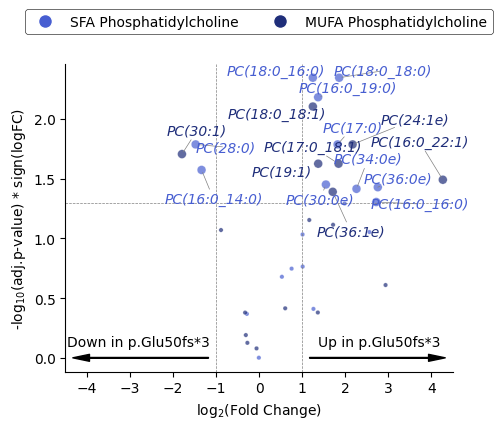

In [30]:
subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('../../../paper/main_plots/G2_PC_volcano_sat.png', dpi=300, bbox_inches='tight')



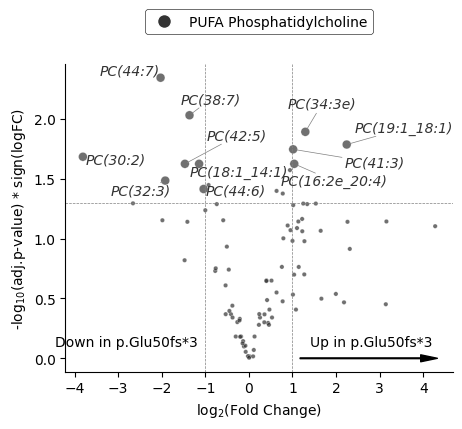

In [31]:
subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('../../../paper/main_plots/G2_PC_volcano_unsat.png', dpi=300, bbox_inches='tight')



/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


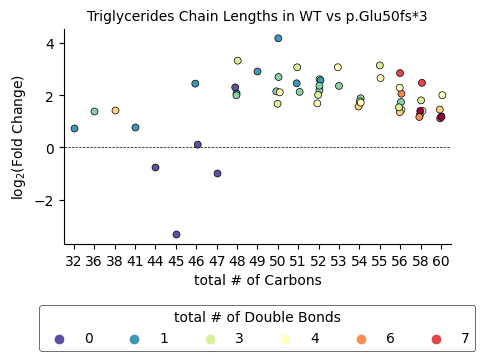

In [17]:
temp = stats[stats['class']=='TG'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/tg_carbons.png', dpi=300, bbox_inches='tight')


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


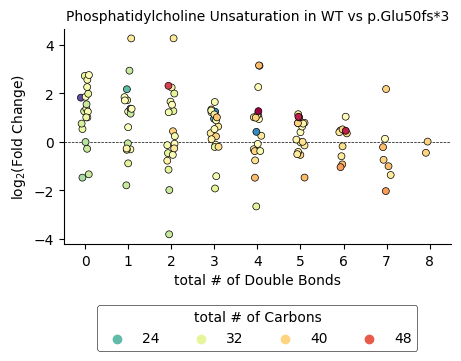

In [18]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Glu50fs*3', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('../../../paper/main_plots/pc_unsat.png', dpi=300, bbox_inches='tight')


#### Look at the two differentiation batches separately in terms of unsaturation of PCs

In [ ]:

###Based on this: emphasis should be on the unsaturated PCs being up 

In [22]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '1096.SUB12877_lipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 

sample_dictionary = {'s1':'WT',
                     's2':'G2',
                     's3':'WT2',
                     's4':'G22',
                     's5':'G2+choline'}


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan


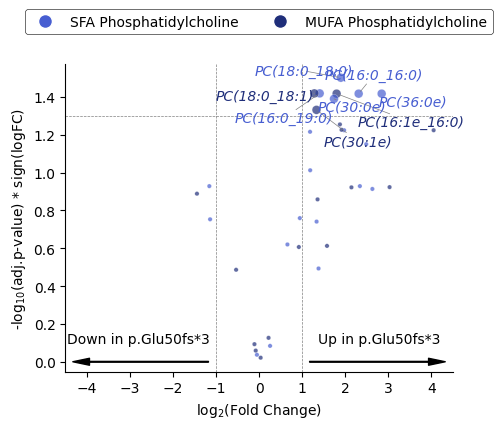

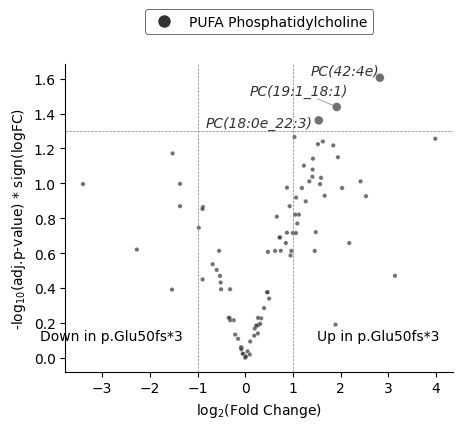

In [27]:
##Diff Batch 1
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT', 'G2')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)



/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan


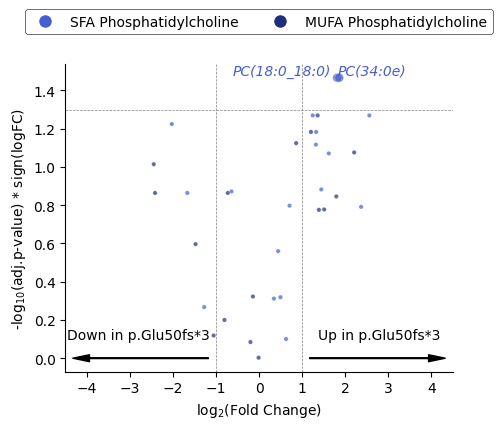

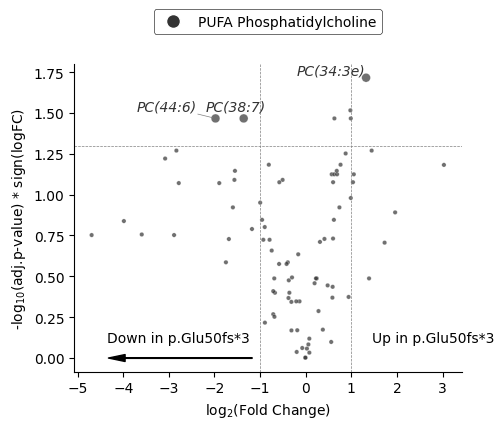

In [26]:
##Diff Batch 2
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# get significant compounds
stats = return_stats(areas, areas_columns, 'WT2', 'G22')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] != 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA',
    'MUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

subset = stats[(stats['class'] == 'PC') & (stats['unsat_grp'] == 'PUFA')].copy()
plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, pufa_palette, force_text=15, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

#plt.xlim(-4.5,4.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(2.8, .1, 'Up in p.Glu50fs*3', ha='center', fontsize=10)

plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'PUFA'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label+' Phosphatidylcholine',
           markerfacecolor=pufa_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)



## Plotting some additional metrics below

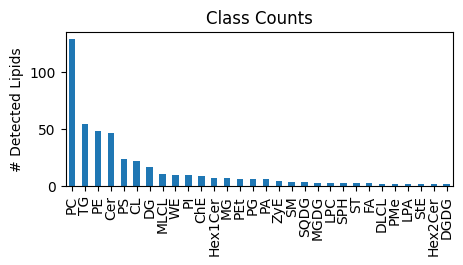

In [83]:
plt.figure(figsize=(5,2))
plot_class_counts(stats)

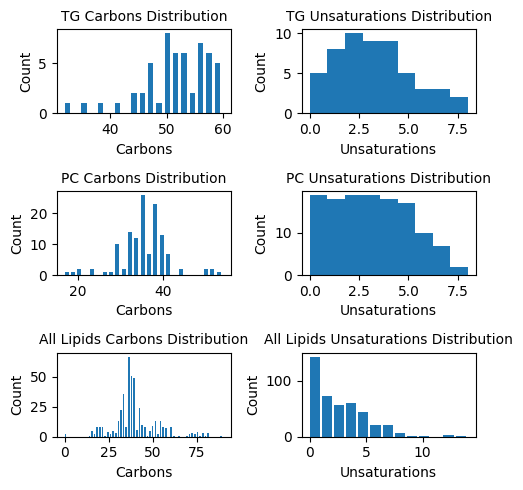

In [84]:
plot_carbon_distributions(stats)

In [85]:
# by group stats
groups = [x.split('(')[0] for x in areas.index]
by_grp = areas.groupby(groups).sum()
by_grp_stats = return_stats(by_grp, areas_columns, 'WT', 'G2')

by_grp_stats['score'] = -1*np.log10(by_grp_stats['p_value']) * np.sign(by_grp_stats['log2_fold_change'])
by_grp_stats.sort_values(by='p_value')

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,score
TG,4.613801,0.003792,1.776767,0.113826,2.421129
StE,4.103992,0.008169,2.271317,0.113826,2.087810
ZyE,3.697210,0.011015,1.849611,0.113826,1.957998
LPC,3.199588,0.016818,1.778882,0.124884,1.774217
MG,-3.047652,0.020143,-1.318765,0.124884,-1.695884
DG,2.793111,0.032596,1.126086,0.168413,1.486835
Hex1Cer,2.441424,0.047167,1.182354,0.208884,1.326359
LPA,2.308368,0.060138,1.259946,0.233036,1.220849
ChE,2.146642,0.068979,0.709867,0.237593,1.161285
Hex2Cer,1.987916,0.099286,2.852471,0.283097,1.003114


In [86]:
# classify fatty acids in TGs
selected_rows_TG = areas[np.array(groups)=='TG']

carbon_counts_classified = np.array([classify_fatty_acid_length(np.round(count_carbons(x)/3)) for x in selected_rows_TG.index])

by_grp = selected_rows_TG.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, areas_columns, 'WT', 'G2')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
LCFA,4.625931,0.003742,1.781950,0.007484
MCFA,3.082965,0.022169,1.265991,0.022169


In [87]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['LCFA', 'MCFA'], dtype='<U4'), array([53,  2]))

In [121]:
# classify fatty acids in PCs
selected_rows_PC = areas[np.array(groups)=='PC']

carbon_counts_classified = np.array([classify_unsaturation(count_unsaturations(x)) for x in selected_rows_PC.index])

by_grp = selected_rows_PC.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, areas_columns, 'WT', 'G2')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
MUFA,-0.054591,0.957914,-0.022241,0.957914
PUFA,0.755013,0.473789,0.247887,0.710683
SFA,2.466305,0.048249,1.133542,0.144748


In [122]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['MUFA', 'PUFA', 'SFA'], dtype='<U4'), array([18, 93, 20]))